<div style="background: linear-gradient(to right, #2c3e50, #3498db); padding: 12px; border-radius: 8px; margin: 10px 0; box-shadow: 0 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: white; text-align: center; font-family: Arial, sans-serif; margin: 0;">
        Part 1 LiDAR BEV Visualisation with NuScenes Dataset
    </h3>
</div>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cv2
from tqdm import tqdm
from pyquaternion import Quaternion


if not hasattr(np, 'Inf'):
    np.Inf = np.inf

In [ ]:
# NuScenes imports
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud
from nuscenes.map_expansion.map_api import NuScenesMap

# Paths
NUSCENES_DIR = '/content/drive/MyDrive/data'
OUTPUT_DIR = 'output_lidar_bev'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load NuScenes
nusc = NuScenes(version='v1.0-mini', dataroot=NUSCENES_DIR, verbose=True)

In [ ]:
def generate_lidar_bev(sample_token, output_path=None):
    sample = nusc.get('sample', sample_token)
    scene = nusc.get('scene', sample['scene_token'])
    lidar_token = sample['data']['LIDAR_TOP']
    lidar_sample = nusc.get('sample_data', lidar_token)
    lidar_filepath = os.path.join(NUSCENES_DIR, lidar_sample['filename'])
    ego_pose = nusc.get('ego_pose', lidar_sample['ego_pose_token'])
    lidar_calib = nusc.get('calibrated_sensor', lidar_sample['calibrated_sensor_token'])

    # Load LiDAR
    pc = LidarPointCloud.from_file(lidar_filepath)
    points = pc.points.copy()

    # Transform LiDAR to ego frame
    points[:3, :] = Quaternion(lidar_calib['rotation']).rotation_matrix @ points[:3, :]
    points[:3, :] += np.array(lidar_calib['translation']).reshape(3, 1)

    # Rotate LiDAR by +yaw to match map mask
    q = Quaternion(ego_pose['rotation'])
    ego_yaw = np.arctan2(2.0 * (q.w * q.z + q.x * q.y), 1.0 - 2.0 * (q.y**2 + q.z**2))
    R_yaw = np.array([
        [np.cos(ego_yaw), -np.sin(ego_yaw)],
        [np.sin(ego_yaw),  np.cos(ego_yaw)]
    ])
    points[:2, :] = R_yaw @ points[:2, :]

    # Filter points
    x_range, y_range = (-50, 50), (-50, 50)
    mask = (points[0, :] >= x_range[0]) & (points[0, :] <= x_range[1]) & \
           (points[1, :] >= y_range[0]) & (points[1, :] <= y_range[1]) & \
           (points[2, :] >= -2.0) & (points[2, :] <= 3.0)
    points = points[:, mask]

    # Setup plot
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_aspect('equal')

    # Map overlay
    log = nusc.get('log', scene['log_token'])
    location = log['location']
    nusc_map = NuScenesMap(dataroot=NUSCENES_DIR, map_name=location)
    patch_box = (ego_pose['translation'][0], ego_pose['translation'][1],
                 x_range[1] - x_range[0], y_range[1] - y_range[0])
    map_masks = nusc_map.get_map_mask(patch_box, -ego_yaw,
                  ['drivable_area', 'ped_crossing', 'walkway'], (800, 800))
    colors = [(0.2, 0.5, 0.2, 0.3), (0.7, 0.2, 0.2, 0.3), (0.2, 0.2, 0.7, 0.3)]
    for i, mask in enumerate(map_masks):
        if mask is not None:
            mask_rgba = np.zeros((800, 800, 4))
            mask_rgba[mask > 0] = colors[i]
            ax.imshow(mask_rgba, origin='lower', extent=[*x_range, *y_range])

    # Plot LiDAR
    ax.scatter(points[0, :], points[1, :], c=points[2, :], cmap='viridis', s=1.5, vmin=0.0, vmax=3.0)

    # Add circular range indicators (10m, 20m, ..., 50m)
    for radius in [10, 20, 30, 40, 50]:
        circle = plt.Circle((0, 0), radius, fill=False, color='black', linestyle='--', alpha=0.2)
        ax.add_patch(circle)
        ax.text(0, radius, f"{radius}m", fontsize=8, ha='left', va='bottom', color='black')

    # Add direction arrows and labels
    directions = {
        'N': (0, 47),
        'E': (47, 0),
        'S': (0, -47),
        'W': (-47, 0)
    }
    for d, (x, y) in directions.items():
        ax.text(x, y, d, fontsize=14, fontweight='bold', ha='center', va='center',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='circle'))

    # Add radar points
    radar_tokens = [sample['data'][k] for k in sample['data'] if 'RADAR' in k]
    for radar_token in radar_tokens:
        try:
            radar_data = nusc.get('sample_data', radar_token)
            radar_filepath = os.path.join(NUSCENES_DIR, radar_data['filename'])
            radar_pc = RadarPointCloud.from_file(radar_filepath)

            # Calibrations and poses
            radar_cs = nusc.get('calibrated_sensor', radar_data['calibrated_sensor_token'])
            radar_pose = nusc.get('ego_pose', radar_data['ego_pose_token'])

            # Transform radar to global
            radar_points = radar_pc.points.copy()
            radar_points[:3, :] = Quaternion(radar_cs['rotation']).rotation_matrix @ radar_points[:3, :]
            radar_points[:3, :] += np.array(radar_cs['translation']).reshape(3, 1)
            radar_points[:3, :] = Quaternion(radar_pose['rotation']).rotation_matrix @ radar_points[:3, :]
            radar_points[:3, :] += np.array(radar_pose['translation']).reshape(3, 1)

            # Transform global to LiDAR ego frame
            lidar_ego_translation = np.array(ego_pose['translation']).reshape(3, 1)
            lidar_ego_rotation = Quaternion(ego_pose['rotation']).rotation_matrix.T  # inverse
            radar_points[:3, :] -= lidar_ego_translation
            radar_points[:3, :] = lidar_ego_rotation @ radar_points[:3, :]

            # Finally rotate to BEV map alignment (+yaw)
            radar_points[:2, :] = R_yaw @ radar_points[:2, :]

            # Filter and plot
            mask = (radar_points[0, :] >= x_range[0]) & (radar_points[0, :] <= x_range[1]) & \
                  (radar_points[1, :] >= y_range[0]) & (radar_points[1, :] <= y_range[1])
            ax.scatter(radar_points[0, mask], radar_points[1, mask],
                      c='red', marker='x', s=10, label='Radar Points')
        except Exception as e:
            print(f"Radar error: {e}")

    sc = ax.scatter([], [], c=[], cmap='viridis', vmin=0.0, vmax=3.0)
    cbar = plt.colorbar(sc, ax=ax, label='Height (m)')

    legend_patches = [
        plt.Rectangle((0, 0), 1, 1, fc=colors[0], label='Drivable Area'),
        plt.Rectangle((0, 0), 1, 1, fc=colors[1], label='Pedestrian Crossing'),
        plt.Rectangle((0, 0), 1, 1, fc=colors[2], label='Walkway'),
        plt.Line2D([0], [0], marker='x', color='w', markerfacecolor='red', label='Radar Points', markersize=10),
        plt.Rectangle((0, 0), 1, 1, fc='blue', alpha=0.7, label='Ego Vehicle')
    ]
    ax.legend(handles=legend_patches, loc='lower right')

    vehicle_length, vehicle_width = 4.5, 2.0
    shape = np.array([
        [-vehicle_width/2, -vehicle_length/2],
        [vehicle_width/2, -vehicle_length/2],
        [vehicle_width/2, vehicle_length/2],
        [0, vehicle_length/2 + 0.5],
        [-vehicle_width/2, vehicle_length/2]
    ])
    rotated_shape = shape @ R_yaw.T
    vehicle_polygon = Polygon(rotated_shape, closed=True, color='blue', alpha=0.7)
    ax.add_patch(vehicle_polygon)

    ax.set_title(f"LIDAR BEV: Scene {scene['name']}, Sample {sample_token[:8]}")
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.close(fig)



Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.181 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


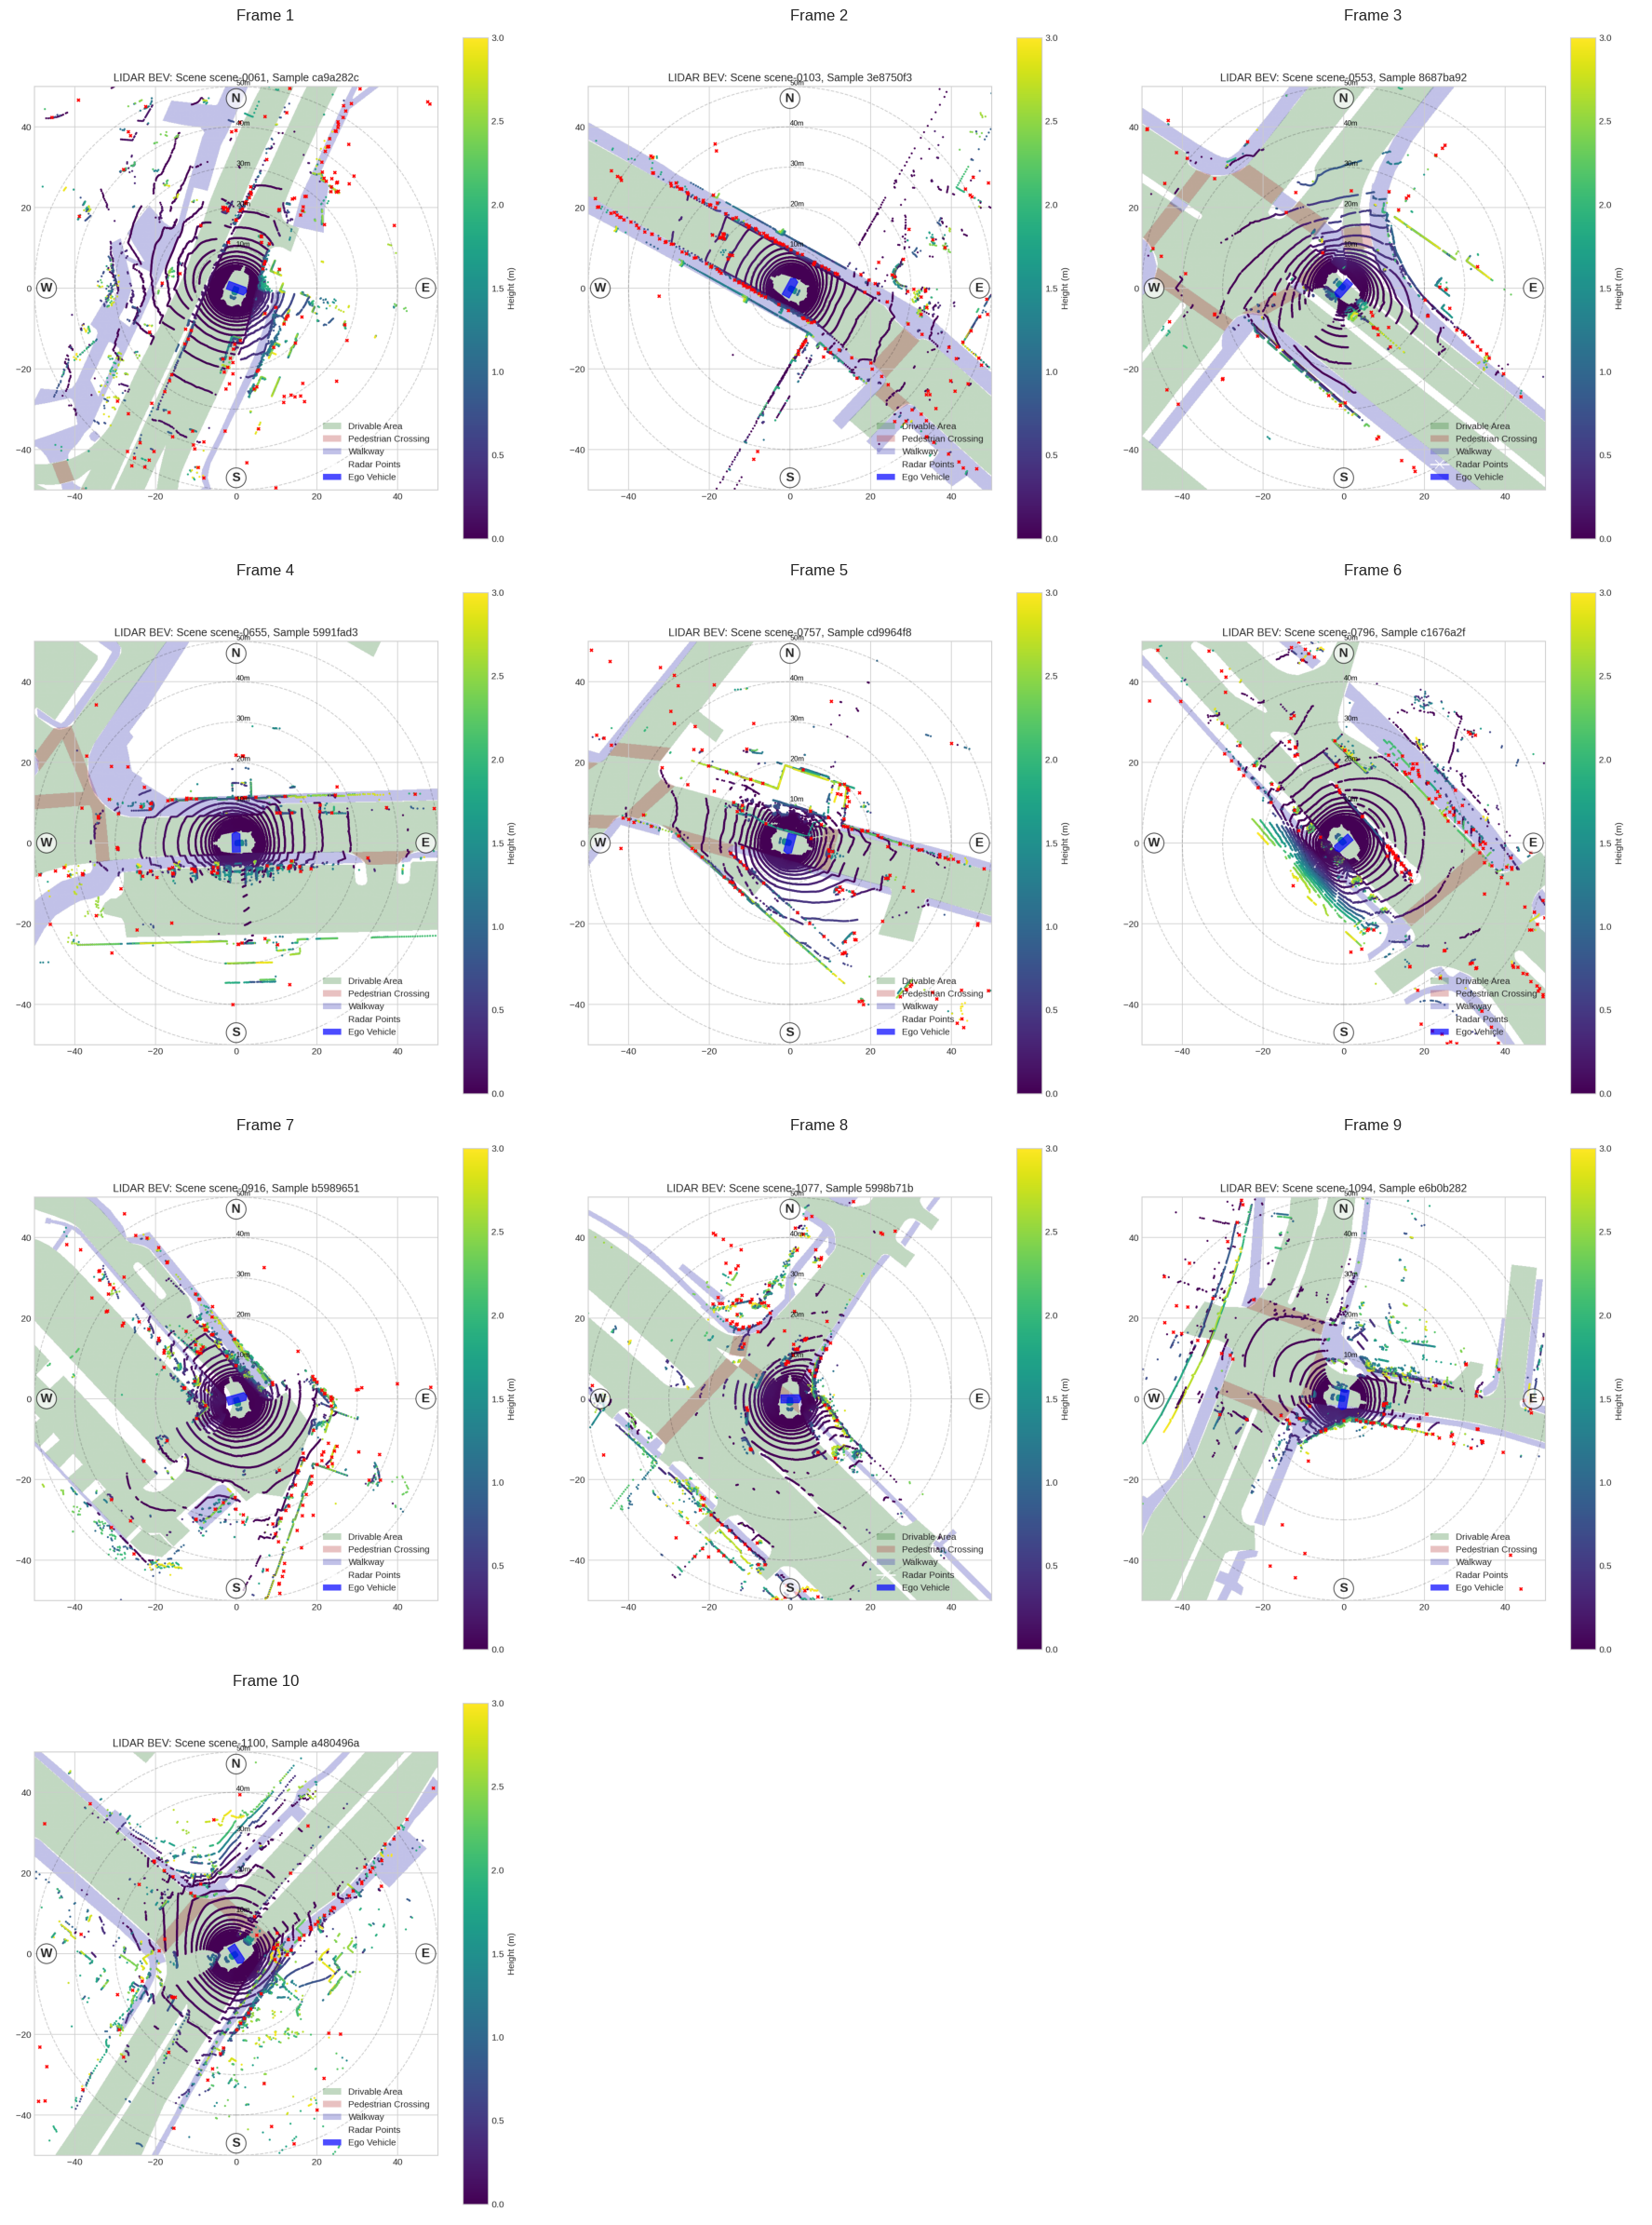

In [4]:
def process_multiple_frames(num_frames=3):
    scene_samples = []
    for scene in nusc.scene:
        token = scene['first_sample_token']
        scene_samples.append((scene['name'], token))

    paths = []
    for i, (name, token) in enumerate(scene_samples[:num_frames]):
        out_path = os.path.join(OUTPUT_DIR, f"lidar_bev_frame_{i+1}.png")
        generate_lidar_bev(token, out_path)
        paths.append(out_path)
    return paths

def create_bev_montage(image_paths, output_path, cols=3):
    n = len(image_paths)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*6))
    axes = axes.flatten()
    for i, path in enumerate(image_paths):
        if os.path.exists(path):
            img = plt.imread(path)
            axes[i].imshow(img)
            axes[i].set_title(f"Frame {i+1}")
            axes[i].axis('off')
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()


frames = process_multiple_frames(num_frames=10)
create_bev_montage(frames, os.path.join(OUTPUT_DIR, "lidar_bev_montage.png"))


# Report Part 1: LiDAR BEV Visualization with NuScenes Dataset

## 1. Introduction and Methodology

For our final research assignment, we implemented a Bird's Eye View (BEV) visualization system using the nuScenes dataset. This approach aligns with our broader goal of developing comprehensive environmental perception for autonomous vehicles, with a focus on visualizing sensor data in an intuitive top-down perspective.

We understood that effective BEV visualization requires:
- Processing LiDAR point cloud data with proper coordinate transformations
- Rendering map overlays for context (drivable areas, pedestrian crossings, walkways)
- Integrating radar data for multi-sensor fusion
- Adding visual elements for better spatial understanding (range indicators, directional markers)

We worked with the nuScenes-mini dataset, which provided various sensor data including LiDAR, radar, and multi-camera views around the vehicle along with map annotations for environmental context.

## 2. Implementation Details

### 2.1 Dataset and Environment Setup

We began by setting up the necessary environment, installing the required dependencies, and mounting the appropriate directories:

- Installed the nuScenes-devkit package for data handling and visualization
- Fixed compatibility issues between different versions of numpy and other libraries
- Established the appropriate folder structure for data access

The nuScenes mini dataset contains 10 scenes with full sensor suite data (LiDAR, radar, cameras), calibration parameters, and map information.

### 2.2 BEV Visualization Framework

We completed the implementation of the LiDAR BEV visualization with the following components:

1. **Point Cloud Processing**:
   - Loading LiDAR data from `.pcd` files
   - Performing coordinate transformations from sensor to ego vehicle frame
   - Applying proper rotation to align with the map perspective
   - Filtering points based on spatial boundaries and height constraints

2. **Map Integration**:
   - Overlaying map elements (drivable areas, pedestrian crossings, walkways) 
   - Aligning map elements with LiDAR data based on ego position and orientation
   - Color-coding different map elements for easy visual distinction

3. **Radar Data Fusion**:
   - Transforming radar points to the same coordinate system as LiDAR
   - Visualizing radar points alongside LiDAR for complementary sensor data
   - Correcting for differences in sensor locations and timestamps

4. **Visualization Enhancements**:
   - Adding circular range indicators (10m, 20m, 30m, 40m, 50m)
   - Including directional markers (N, E, S, W)
   - Representing the ego vehicle with appropriate dimensions and orientation
   - Generating a color-coded height map for LiDAR points

### 2.3 Multi-Frame Processing

To complete the assignment requirements, we implemented a framework to process multiple frames:

- Created a pipeline to generate BEV visualizations for 10 different frames
- Developed a montage creation function to display all frames in a single visualization
- Ensured consistent styling and scaling across all frames

This approach allowed us to visualize the vehicle's journey through the environment across multiple timepoints, providing context for the vehicle's motion and the changing surroundings.

## 3. Results and Analysis

### 3.1 Visualization Quality

Our implemented BEV visualization system successfully rendered high-quality representations of the environment around the vehicle. The visualizations clearly show:

- Road structure and drivable areas (green)
- Pedestrian crossings (red) and walkways (blue)
- LiDAR points with height-based coloring
- Radar detections as red markers
- Ego vehicle position and orientation (blue rectangle)
- Range indicators and directional markers for spatial reference

The montage of 10 frames provides a comprehensive view of different driving scenarios, including intersections, straight road segments, and areas with varying density of surrounding objects.

### 3.2 Technical Assessment

Analyzing our implementation, we found several key technical aspects:

1. **Coordinate Transformations**: The most challenging aspect was ensuring correct coordinate transformations between different reference frames. We implemented proper quaternion-based rotations to align the LiDAR data with the map view.

2. **Radar Integration**: Successfully integrating radar data required careful calibration and transformation, particularly accounting for different sensor locations and timestamps.

3. **Visual Clarity**: By using a consistent color scheme and adding intuitive reference markers, we created visualizations that effectively communicate the spatial relationships of different elements.

4. **Map Overlay**: The map overlays provide crucial context for understanding the environment structure, making the visualizations more interpretable for both humans and potential downstream algorithms.

## 4. Limitations and Challenges

During our implementation, we encountered several challenges:

1. **Dependency Management**: The nuScenes-devkit had specific version requirements that conflicted with other libraries, requiring careful environment management.

2. **Sensor Alignment**: Achieving precise temporal and spatial alignment between different sensor modalities (LiDAR and radar) required careful handling of transformation matrices and timestamps.

3. **Depth Representation**: Representing 3D LiDAR data in a 2D BEV required careful consideration of color mapping and visual cues to preserve depth information.

4. **Scale and Boundaries**: Determining appropriate spatial boundaries and scale for effective visualization required balancing detail with overall context.

5. **Processing Efficiency**: Working with multiple frames of high-density point clouds required attention to computational efficiency.

## 5. Future Improvements and Connection to Part 2

Looking ahead to Part 2 of this assignment, we plan to use these LiDAR-based BEV visualizations as ground truth for developing a camera-only BEV system. Specifically:

### 5.1 Ground Truth for Supervised Learning

The high-quality BEV maps generated in Part 1 will serve as reference data for training and evaluating our camera-based approach in Part 2. These visualizations provide:

- Accurate positioning of objects and road features in the BEV space
- Clear delineation of drivable areas, pedestrian crossings, and walkways
- Reference points for evaluating the accuracy of our DepthAnythingV2+YOLO approach

### 5.2 Loss Function Development

For Part 2, we will need to develop a robust loss function that can measure the difference between our camera-based BEV predictions and these LiDAR-based ground truth visualizations. We plan to explore:

1. **Pixel-wise Comparison**: Comparing corresponding pixels between the predicted and ground truth BEV maps for drivable areas and other map elements.

2. **Object Position Error**: Measuring the positional error of detected objects in the BEV space.

3. **Structural Similarity**: Using metrics like Structural Similarity Index (SSIM) to capture perceptual differences between the images.

4. **Feature Matching**: Comparing extracted features from both BEV representations.

### 5.3 Towards Camera-Only BEV Generation

Our ultimate goal for Part 2 is to develop a system that can generate accurate BEV maps using only camera inputs through:

1. Depth estimation using DepthAnythingV2
2. Object detection using YOLOv11
3. Projection of detected objects into BEV space
4. Integration with map data for context

The LiDAR-based BEV maps created in Part 1 provide the necessary ground truth to make this camera-only approach possible and evaluable.

## 6. Conclusion

Our implementation of LiDAR-based BEV visualization demonstrates the effectiveness of fusing different sensor modalities and map data into an intuitive top-down view. The system successfully integrates LiDAR point clouds, radar detections, and map information to create comprehensive environmental representations from multiple perspectives.

These visualizations not only provide valuable insights for human understanding but will also serve as essential ground truth data for our future work on camera-only BEV generation. By establishing this solid foundation in Part 1, we are well-positioned to tackle the more challenging camera-based approach in Part 2 of our research assignment.

The BEV representation bridges the gap between raw sensor data and high-level decision making, making it a critical component for autonomous vehicle perception systems. Our implementation provides a robust baseline for future development and evaluation of more efficient perception methods.